# EECS531 - A5
#### Tristan Maidment [tdm47]

#### Goal
The purpose of this assignment is to comment all of the code provided to demonstrate our understanding of the material.  In order to better understand the functionality, I re-implemented the logic in numpy/python.

### Implementation/Explanation

This function is used to define the object viewed by the cameras.  A cube represented by 9 points are defined in space.  The simulation coordinates are with respect to the center of projection.  This means that the center of the cube is located at the center of projection, at location `[0, 0, 0]`.

In addition, it provides a color map for easy point identification.

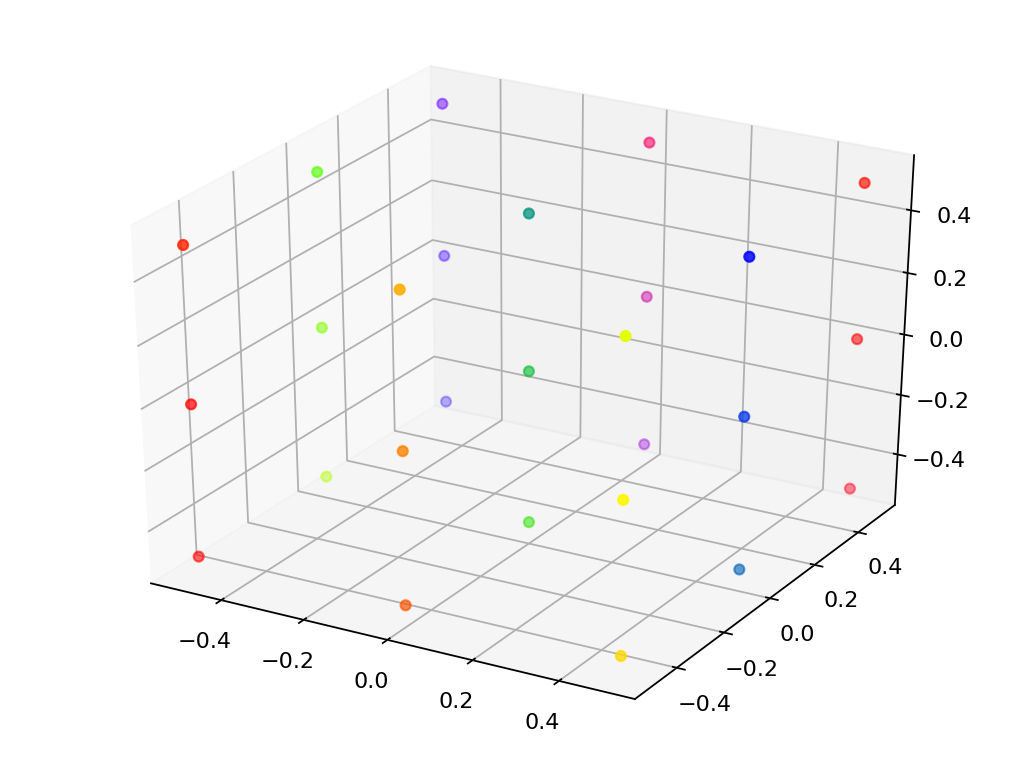

In [52]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def create_points():
    X, Y, Z = np.meshgrid([-0.5, 0, 0.5], [-0.5, 0, 0.5], [-0.5, 0, 0.5])
    points = np.vstack([np.ravel(X), np.ravel(Y), np.ravel(Z)])
    return points, plt.cm.prism(range(points[0].shape[0]))

points, colors = create_points();
fig = plt.figure(figsize=(8, 6), dpi=160)
ax = fig.gca(projection='3d')
ax.scatter(points[0], points[1], points[2], c=colors, marker="o")
plt.show()

In addition, both cameras must be defined.

**Position** -  Since the coordinate system being used is with respect to the center of projection, the position of the cameras is specified with a distance of 5 units from the object.

**Target** - This defines the focal point of the camera.  Since the camera is focusing on the cube defined at `[0, 0, 0]`, the focal point is also located here.

**Up** - This metric is used to define the "up" vector, specifically for when converting to the camera coordinate system.

**Focal_Length** - Specifies the distance between the lens and detector.

**Film_Width/Film_Height** - These values represent the size of the  dimensions of the detector element within the camera.

**Width/Height** - The width and height represents the size (in pixels) of the plane being at the focal point.  The ratio between `height` and `width` is equal to that of the `film_width` and `film_height`.



In [2]:
def preset_cameras():
    r = 5
    alpha = np.pi/6
    beta = np.pi/6
    cam1 = {'position': np.asarray([r*np.cos(beta)*np.cos(alpha), r*np.cos(beta)*np.sin(alpha), r*np.sin(beta)]),
            'target': np.asarray([0, 0, 0]),
            'up': np.asarray([0, 0, 1]),
            'focal_length': 0.06, 
            'film_width': 0.035,
            'film_height': 0.035,
            'width': 256,
            'height': 256}
    alpha = np.pi/3
    cam2 = {'position': np.asarray([r*np.cos(beta)*np.cos(alpha), r*np.cos(beta)*np.sin(alpha), r*np.sin(beta)]),
            'target': np.asarray([0, 0, 0]),
            'up': np.asarray([0, 0, 1]),
            'focal_length': 0.06, 
            'film_width': 0.035,
            'film_height': 0.035,
            'width': 256,
            'height': 256}
    return cam1, cam2

**zcam** - This function determines the coordinate system of the camera by first finding the vector between the target and the camera origin, labeled `zcam`.  This axis goes from the target to the origin of the camera, and represents depth.

**xcam** - `xcam` is determined by taking the cross product of zcam and the "up" vector, which determines the horizontal axis of the camera.

**ycam** - `ycam` uses this horizontal axis, `xcam`, and the distance axis, `zcam`, to determine the vertical axis.

In [3]:
def camera_coordinate_system(cam):
    # determine camera distance from target
    zcam = cam['target'] - cam['position']
    xcam = np.cross(zcam, cam['up'])
    ycam = np.cross(zcam, xcam)
    
    zcam /= np.linalg.norm(zcam)
    xcam /= np.linalg.norm(xcam)
    ycam /= np.linalg.norm(ycam)
    
    origin = cam['position']
    return xcam, ycam, zcam, origin

`plot_camera` draws the camera acquisition geometry in the object space, to demonstrate the positioning of each camera.  Using the camera coordinate system, `plot_camera` uses both the `film_width` and `focal_length` to determine the four corner points of the camera acqusition plane.  The camera is drawn with the "origin" being the location of the lens.

To calculate the location of the four corners of the acquisiton plane, the location of the four corners of the detector determined first.  A line can be drawn from the four corners of the detector to the opposite corners in the acquisition plane, through the center of the lens.  Since the center of the detector is in line with the center of the lense, only two values, `x` and `y`, can represent the the distance from the center in the X and Y axis. By varying the sign of `x` and `y`, we can represent all four points `(x,y)`, `(-x,y)`, `(x,-y)`, `(-x,-y)`.  Distance `d` between the target and the camera, and is divided by the `focal_length` to properly scale `x` and `y` from detector size to acquisition plane size.

After calculating `x`, `y`, and `d`, the axis of the acquisition plane can be determined.  The external geometry is exactly the same as the internal geometry, but flipped. 

After determining the four points in the acquisition plane, the plane is rendered in 3D, and lines are drawn from the lense to the points, to visualize the projection.

In [120]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import art3d

def plot_camera(cam, label, color):
    
    xcam, ycam, zcam, origin = camera_coordinate_system(cam)
    
    d = np.linalg.norm(cam['target'] - cam['position'])
    x = 0.5 * cam['film_width'] * d / cam['focal_length']
    y = 0.5 * cam['film_width'] * d / cam['focal_length']
    
    #label the camera
    ax.text(origin[0], origin[1], origin[2], label)
    
    # determine the four points on the acquisition plane corners
    P1 = origin + x * xcam + y * ycam + d * zcam
    P2 = origin + x * xcam - y * ycam + d * zcam
    P3 = origin - x * xcam - y * ycam + d * zcam
    P4 = origin - x * xcam + y * ycam + d * zcam
    
    connect = lambda p1, p2: ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], c=color)
    
    plane = np.stack([P1, P2, P3, P4])
    ax.plot_trisurf(plane[:,0], plane[:,1], plane[:,2], color=color)
    
    connect(cam['position'], cam['target'])
    connect(cam['position'], P1)
    connect(cam['position'], P2)
    connect(cam['position'], P3)
    connect(cam['position'], P4)

In [122]:
points, colors = create_points();
cam1, cam2 = preset_cameras();

To visualize the virtual world, a single camera is drawn, with respect to the object.

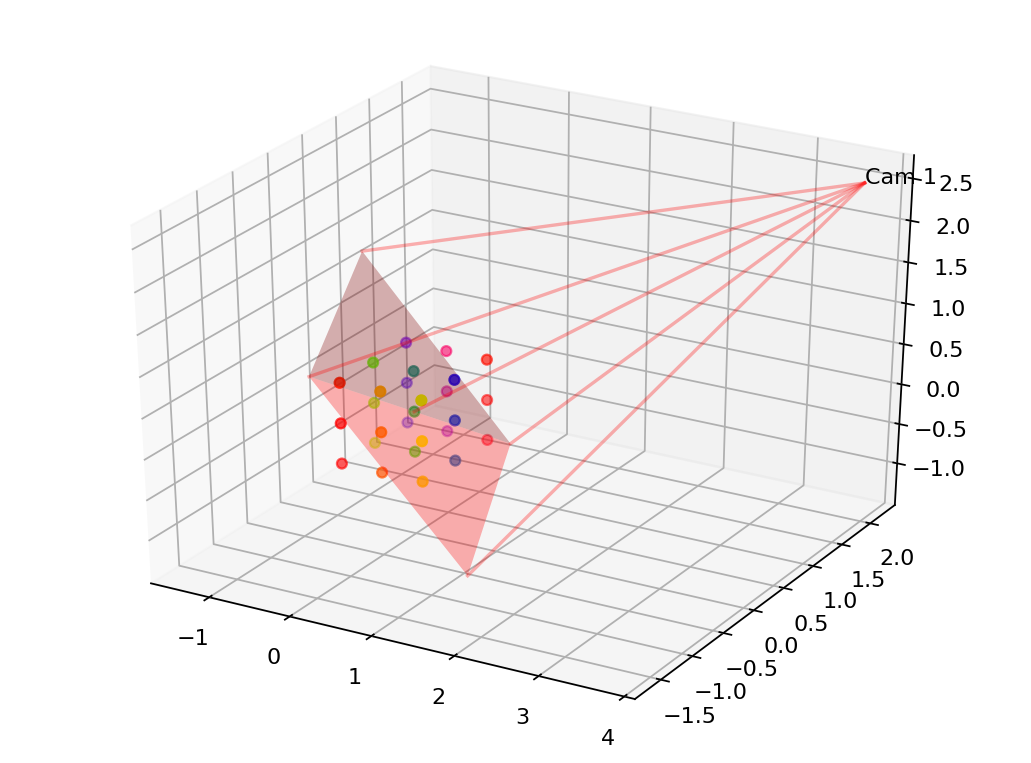

In [117]:
fig = plt.figure(figsize=(8, 6), dpi=160)
ax = fig.gca(projection='3d')
plot_camera(cam1, 'Cam 1', np.asarray([1, 0, 0, 0.3]))
ax.scatter(points[0], points[1], points[2], c=colors) 
plt.show()

Triangulation requires two cameras to work properly.  Acquiring 3D structure can only be done reliably with two cameras, with a decent amount of distance between them.  In addition, they must be angled so that the focal point is at the same spot.  This models what our eyes do naturally.  

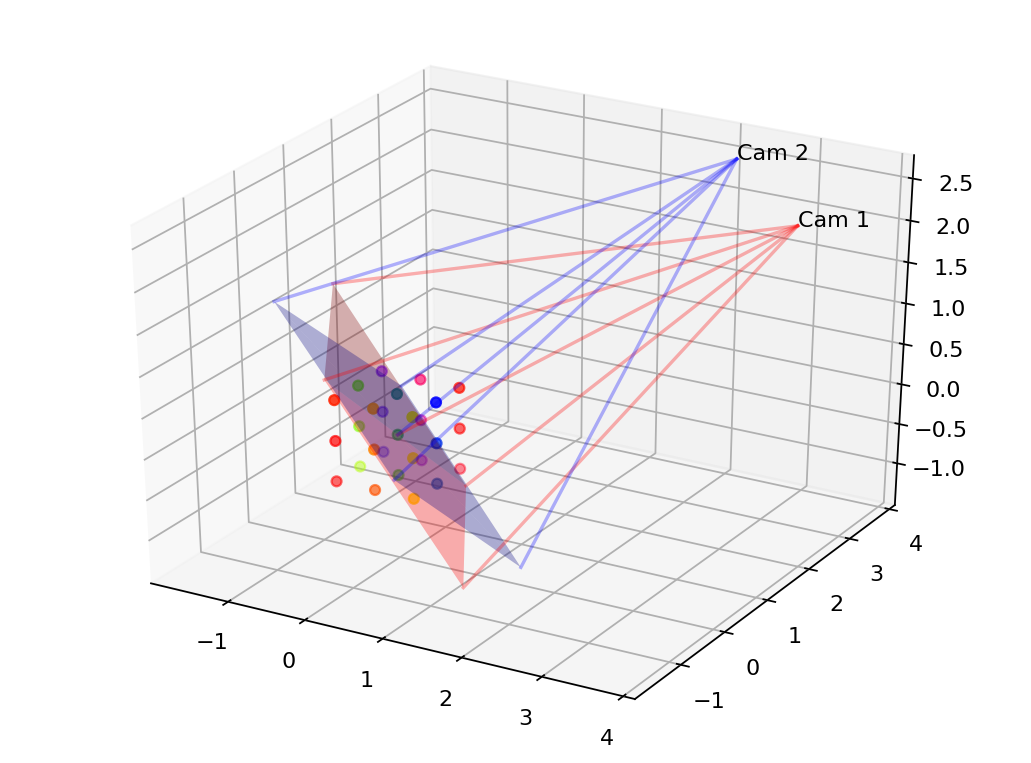

In [118]:
fig = plt.figure(figsize=(8, 6), dpi=160)
ax = fig.gca(projection='3d')
plot_camera(cam1, 'Cam 1', np.asarray([1, 0, 0, 0.3]))
plot_camera(cam2, 'Cam 2', np.asarray([0, 0, 1, 0.3]))
ax.scatter(points[0], points[1], points[2], c=colors) 
plt.show()

#### Extrinsic Matrix
The Extrinsic Matrix is used to represent the position of the camera with respect to the the object coordinates. Earlier, the function `camera_coordinate_system` was defined, and provided the euclidian coordinates of the camera.  This provides the cameras rotation, with respect to the origin object.  However, to properly specify the camera position, a *translation vector*, `t`, is needed to where the camera is with respect to the object in the camera coordinate system.  

The extrinsic matrix, `E` is defined as:

\begin{equation*}
\mathbf{E} =
\ [R|t]\\
\end{equation*}

`R` is the rotation matrix, found via `camera_coordinate_system`.  Vector `t` is found via `t = -RC`.  Note that in the example provided, this dot product must be done as `t = C @ -R`, due to the fact that the example code put the translation vector at the bottom of the matrix, instead of the right side.

After finding `t`, we just append it to the end of the rotation matrix to find `E`.

In [109]:
def ExtrinsicsMtx(cam):
    xcam, ycam, zcam, origin, = camera_coordinate_system(cam)
    
    #rotation matrix
    R = np.asarray([np.ravel(xcam), np.ravel(ycam), np.ravel(zcam)]).T
    
    #translation vector
    t = origin @ -R
    
    M = np.vstack([R, t])
    return M

#### Intrinsic Matrix
The Intrinsic Matrix models the image parameters after the image "hits" the lens.  They way that the image hits the detector, or film, is generally inverted and a different size.  To accurately recreate the acquired data, the intrinsic matrix must be solved. The matrix takes the form:

\begin{equation*}
\mathbf{K} =  \begin{vmatrix}
\ F_x & 0 & 0 \\
\ s & F_y & 0 \\
\ cx & cy & 1 \\
\end{vmatrix}
\end{equation*}

`Fx` and `Fy` are the adjusted focal length, or the distance from the lens to the detector.  To convert the focal length, the equation `Fx = fx(W/w)` is used, where `fx` is the focal length and `W` is the camera width in pixels, and `w` is the width of the detector.

`cx` and `cy` are the Principle Point Offset, which is used to determine location of the principle point, or center of the image input, with respect to the detector.

These values are very important for real world cameras, where the parameters can vary signifcantly.  Since this example is completely virtual, there is no variability in this example.

In [103]:
def IntrinsicsMtx(cam):
    cx = 0.5 * (cam['width'] + 1)
    cy = 0.5 * (cam['height'] + 1)
    
    fx = cam['focal_length'] * cam['width'] / cam['film_width']
    fy = cam['focal_length'] * cam['height'] / cam['film_height']
    
    return np.asarray([[fx, 0, 0], [0, fy, 0], [cx, cy, 1]])

#### Camera Matrix
Together, the extrinsic and intrinsic matrix create a full representation of the camera geometry.  The Camera matrix, `P` is found with the equation:

\begin{equation*}
\mathbf{P} = 
\ K[R | -RC]\\
\end{equation*}

As we can see, it is simply the product of the intrinsic matrix `K` and the extrinsic matrix `[R | -RC]`.



In [104]:
def CameraMtx(cam):
    return ExtrinsicsMtx(cam) @ IntrinsicsMtx(cam)

`world2image` uses the camera matrix previously defined to convert the 3D points defined earlier to the 2D coordinates interpreted by the detector.  The camera matrix defines the transform from 3D object space to the 2D space of the detector.  It makes converting the points as easy as computing the dot product between each 3D point and the camera matrix.  However, in order for the 3D points to be able to be converted, they must be homogenous.  A `1` is appended to the end of each point.

The result is a series of homogenous 2D points.  To ensure that the scaling is correct, they are divided by the third (homogenous) term.

In [105]:
def world2image(cam, points3d):
    P = CameraMtx(cam);
    A = points3d.T
    
    # make points homogenous
    B = np.ones((int(points.size/3), 1))
    pt = np.hstack([A, B])
    
    #convert from 3D -> 2D
    pt = pt @ P
    
    #scale the points 
    x = pt[:, 0] /pt[:,2]
    y = pt[:, 1] / pt[:,2]
    return np.asarray([x, y])

This function draws the "view" from each camera.  After finding the location of each point in 2D, a circle is drawn at that point.  This represents the process for which a detector reconstructs the 3D world in 2D.

In [106]:
def setcolor(I, points2d, colors, R):
    h, w, channels = I.shape
    for i in range(points2d.shape[1]):
        x = points2d[0, i]
        y = points2d[1, i]
        
        r1 = int(max(1, np.floor(y-R)))
        r2 = int(min(h, np.ceil(y+R)))
        c1 = int(max(1, np.floor(x-R)))
        c2 = int(min(w, np.ceil(x+R)))
        
        ## draw a circle at each point
        for r in range(r1, r2):
            for c in range(c1, c2):
                if (r-y)**2 + (c-x)**2 < (R**2):
                    I[r, c, :] = colors[i, :3]
    return I

The figures below show the 2D projections from camera 1 and camera 2.

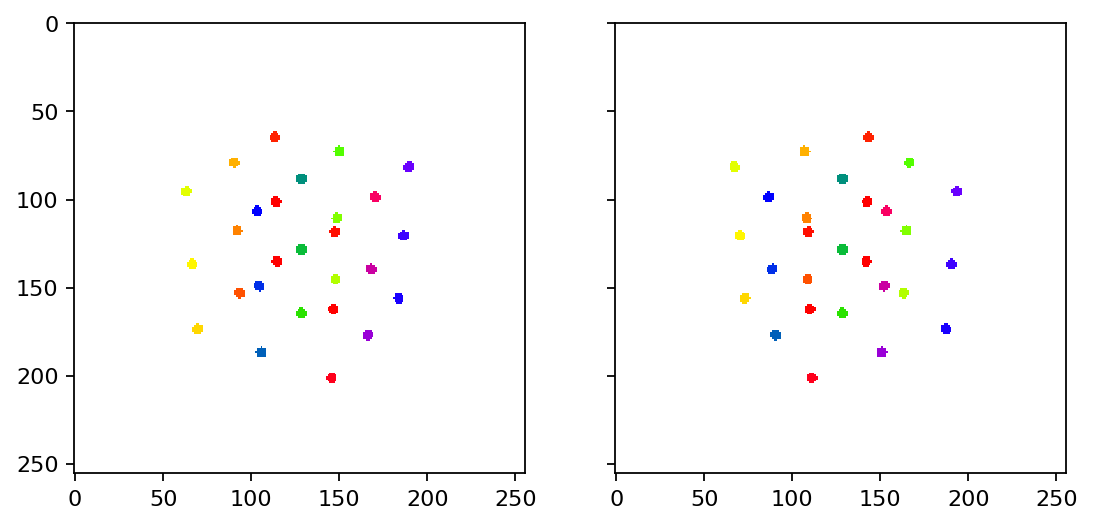

In [129]:
radius = 3
px1 = world2image(cam1, points)
px2 = world2image(cam2, points)
I1 = setcolor(np.ones((cam1['height'], cam1['width'], 3)), px1, colors, radius)
I2 = setcolor(np.ones((cam2['height'], cam1['width'], 3)), px2, colors, radius)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 6), dpi=160)
ax1.imshow(I1)
ax2.imshow(I2)
plt.show()

### Triangulation
Triangulation is the process of taking two seperate projections, their camera matrices, and reconstruct the original scene.

**Triangulate** - The triangulate function takes the homogenous 2D point locatons that would be acquired by the two cameras, and the camera matrices.  Each point is triangulated seperately, and the non-homogenous estimated 3D point for each one is found.

**TriangulationOnePoint** - This method takes a the 2D location of a point with respect to two cameras, and the camera matrix.  Triangulation can by defining a set of four linear equations, and using SVD to determine a least squares solution to find the location of the point in question.

The 2D points provided by each camera can be both found by a unknown transformation, `X`.  This relationship can be modeled by:

\begin{equation*}
\mathbf{x_1} = P_1X\
\end{equation*}
and
\begin{equation*}
\mathbf{x_2} = P_2X\
\end{equation*}
the lower case `x` represents the 2D homogenous point, and the upper case `X` represents the 3D world point.

If an imaginary line was drawn between the center of each camera detector and between each center and point X, a triangle is created.  This is where the term "triangulation" is coined from.

`P_1` and `P_2` can be combined to create, matrix A.  By setting `AX = 0`, the solution for A can be found via least squares, which is the 3D point that most makes the equation closest to 0.

Then, the point is simply made non-homogenous, by dividing out the fourth term.

In [126]:
def triangulate(points1, points2, P1, P2):
    pixels = points1.shape[1]
    points3d = np.zeros((pixels, 3))
    
    for i in range(pixels):
        points3d[i] = triangulationOnePoint(points1[:,i], points2[:,i], P1.T, P2.T)
    return points3d

def triangulationOnePoint(point1, point2, P1, P2):
    A = np.zeros((4, 4))
    A[0:2] = (np.outer(point1, P1[2,:])) - P1[0:2,:]
    A[2:4] = (np.outer(point2, P2[2,:])) - P2[0:2,:]
    
    u, s, V = np.linalg.svd(A)
    V = V.T
    X = V[:,-1]
    X /= X[-1]
    
    return X[0:3].T


As we can see, this method works well in finding the original terms.  To model the reconstruction, the original points are drawn with a vertical bar, and the reconstructed points are drawn with a horizontal bar.

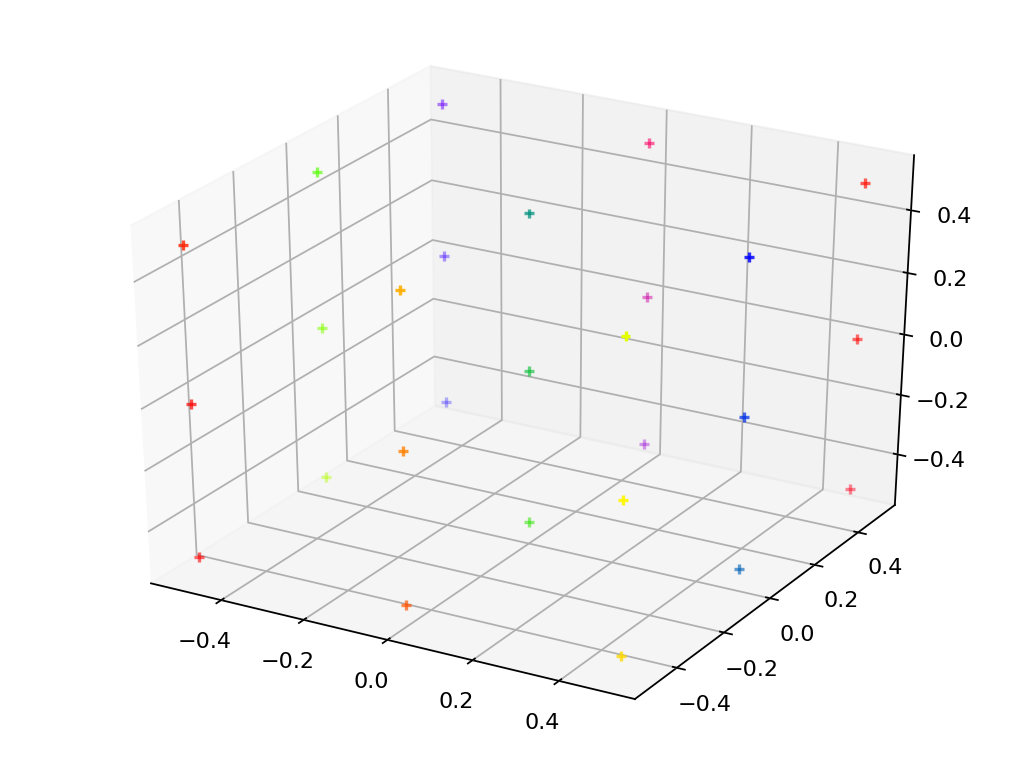

In [127]:
P1 = CameraMtx(cam1)
P2 = CameraMtx(cam2)
rec = triangulate(px1, px2, P1, P2)
fig = plt.figure(figsize=(8, 6), dpi=160)
ax = fig.gca(projection='3d')
ax.scatter(points[0], points[1], points[2], c=colors, marker="|")
ax.scatter(rec.T[0], rec.T[1], rec.T[2], c=colors, marker="_")
plt.show()

### Conclusion
Camera geometry requires the combination of a couple of special techniques and simple geometry.  However, this model was overly simplified, and the process of recreating it and learning the math indicates to me that the application of these methods in real world problems could express a variety of issues.  Some of these issues include variences in camera contrast, warping, and other optical/lens properties that were unaccounted for in this example.